In [218]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as np
from jax import lax, random
from jax.scipy.special import expit as logistic

import numpyro as pn
from numpyro import sample
from numpyro import deterministic
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import warnings
pn.set_platform("cpu")
pn.set_host_device_count(4)

In [219]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Sep 08 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

jax       : 0.3.17
pandas    : 1.4.4
arviz     : 0.12.1
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:38:29) [Clang 13.0.1 ]
matplotlib: 3.5.3
numpyro   : 0.10.1

Watermark: 2.3.1



In [220]:
## for jax's RNG
def key_gen(seed = random.PRNGKey(8927)):
    def key():
        nonlocal seed
        seed, new_key = random.split(seed)
        return new_key
    return key

key = key_gen()

In [221]:
d = pd.read_csv("Data/reedfrogs.csv", sep=',')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   density   48 non-null     int64  
 1   pred      48 non-null     object 
 2   size      48 non-null     object 
 3   surv      48 non-null     int64  
 4   propsurv  48 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ KB


In [222]:
dat = dict(S = d.surv.values, N = d.density.values, tank = d.index.values)

## separate intercept for each tank
def model1(tank, N, S):
    a = sample("a", dist.Normal(0, 1.5), sample_shape=tank.shape)
    logit_p = a[tank]
    p = deterministic("p", logistic(logit_p))
    ## logit link is built in
    sample("S", dist.Binomial(N, logits=logit_p), obs = S)

In [ ]:
m1 = MCMC(NUTS(model1), num_warmup=500, num_samples=500, num_chains=4)
m1.run(key(), **dat)

In [17]:
## multi-level model
def model2(tank, N, S):
    abar = sample("a_bar", dist.Normal(0, 1.5))
    asig = sample("a_sigma", dist.Exponential(1))
    a = sample("a", dist.Normal(abar, asig), sample_shape=tank.shape)
    logit_p = a[tank]
    p = deterministic("p", logistic(logit_p))
    ## logit link is built in
    sample("S", dist.Binomial(N, logits=logit_p), obs = S)

In [ ]:
m2 = MCMC(NUTS(model2), num_warmup=500, num_samples=500, num_chains=4)
m2.run(key(), **dat)

In [42]:
az.summary(m2, var_names=['~a', '~p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.334,0.253,0.875,1.805,0.006,0.004,1698.0,1634.0,1.0
a_sigma,1.619,0.211,1.213,1.991,0.007,0.005,1062.0,1630.0,1.0


In [21]:
az.compare({"m1": m1, "m2": m2},
    ic="waic", scale="deviance", method="BB-pseudo-BMA")

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2,0,200.195408,21.055922,0.000000,0.996962,4.507849,0.000000,True,deviance
m1,1,214.895531,25.783352,14.700123,0.003038,7.079112,3.706724,True,deviance


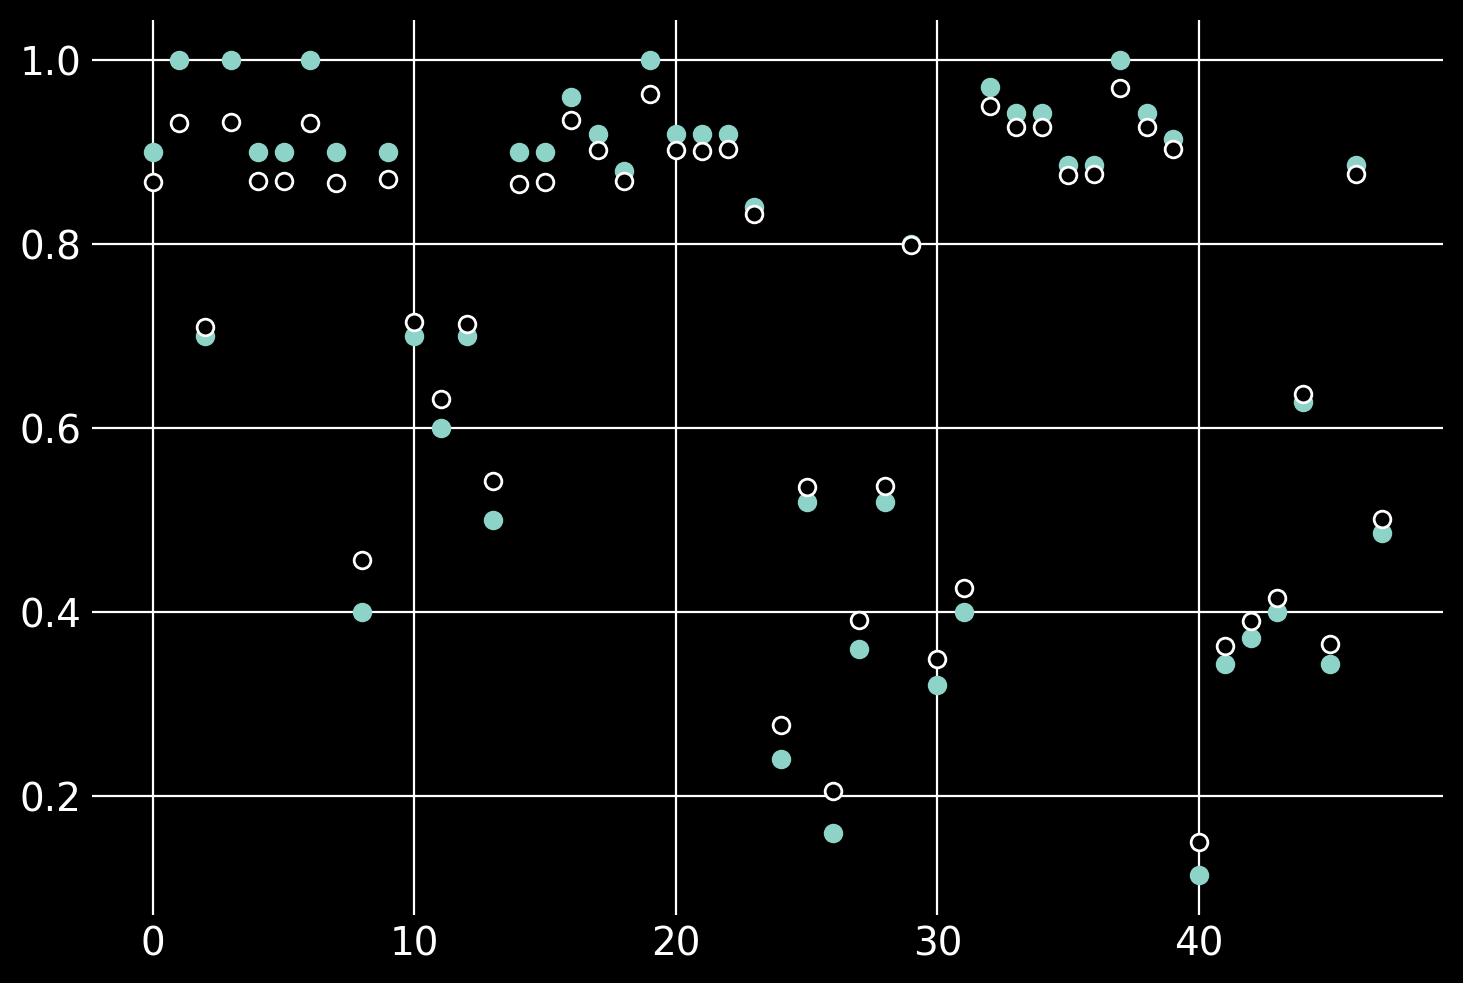

In [40]:
post2 = m2.get_samples()

_, ax = plt.subplots()
ax.scatter(d.index.values, d["propsurv"], marker="o")
ax.scatter(d.index.values, post2['p'].mean(0), marker="o", color="k", edgecolor="w");


In [44]:
d = pd.read_csv("Data/chimpanzees.csv", sep=';')
d["actor"] -= 1
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,0,NaN,0,1,2,0,1,0,0
1,0,NaN,0,1,4,0,0,1,0
2,0,NaN,0,1,6,1,0,0,1
3,0,NaN,0,1,8,0,1,0,0
4,0,NaN,0,1,10,1,1,1,1


In [45]:
actor_idx, actors = pd.factorize(d["actor"])
treatment_idx, treatments = pd.factorize(d["treatment"])
block_idx, blocks = pd.factorize(d["block"])

In [50]:
def model(actor, block_id, treatment, pulled_left=None):
    a_bar = sample("a_bar", dist.Normal(0, 1.5))
    a_sig = sample("a_sigma", dist.Exponential(1))
    g_sig = sample("g_sigma", dist.Exponential(1))
    a = sample("a", dist.Normal(a_bar, a_sig), sample_shape=actors.shape)
    g = sample("g", dist.Normal(0, g_sig), sample_shape=blocks.shape)
    b = sample("b", dist.Normal(0, 0.5), sample_shape=treatments.shape)
    logit_p = a[actor] + g[block_id] + b[treatment]
    deterministic("p", logistic(logit_p))
    sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

In [ ]:
dat = dict(pulled_left = d['pulled_left'].values,
    actor = actor_idx,
    block_id = block_idx,
    treatment = treatment_idx)

m4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m4.run(key(), **dat)

In [58]:
m4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.36      0.36     -0.37     -0.96      0.22    543.55      1.00
      a[1]      4.68      1.29      4.45      2.72      6.56    664.22      1.00
      a[2]     -0.66      0.37     -0.65     -1.30     -0.07    518.98      1.00
      a[3]     -0.67      0.37     -0.67     -1.27     -0.05    594.51      1.00
      a[4]     -0.37      0.36     -0.37     -0.95      0.23    583.08      1.00
      a[5]      0.58      0.36      0.57      0.02      1.18    567.35      1.00
      a[6]      2.11      0.47      2.10      1.28      2.82    766.54      1.00
     a_bar      0.59      0.69      0.61     -0.56      1.67   1450.91      1.00
   a_sigma      2.01      0.66      1.91      1.00      2.85    960.37      1.00
      b[0]     -0.13      0.31     -0.12     -0.66      0.34    566.70      1.00
      b[1]      0.40      0.31      0.41     -0.07      0.93    608.49      1.00
      b[2]     -0.47      0

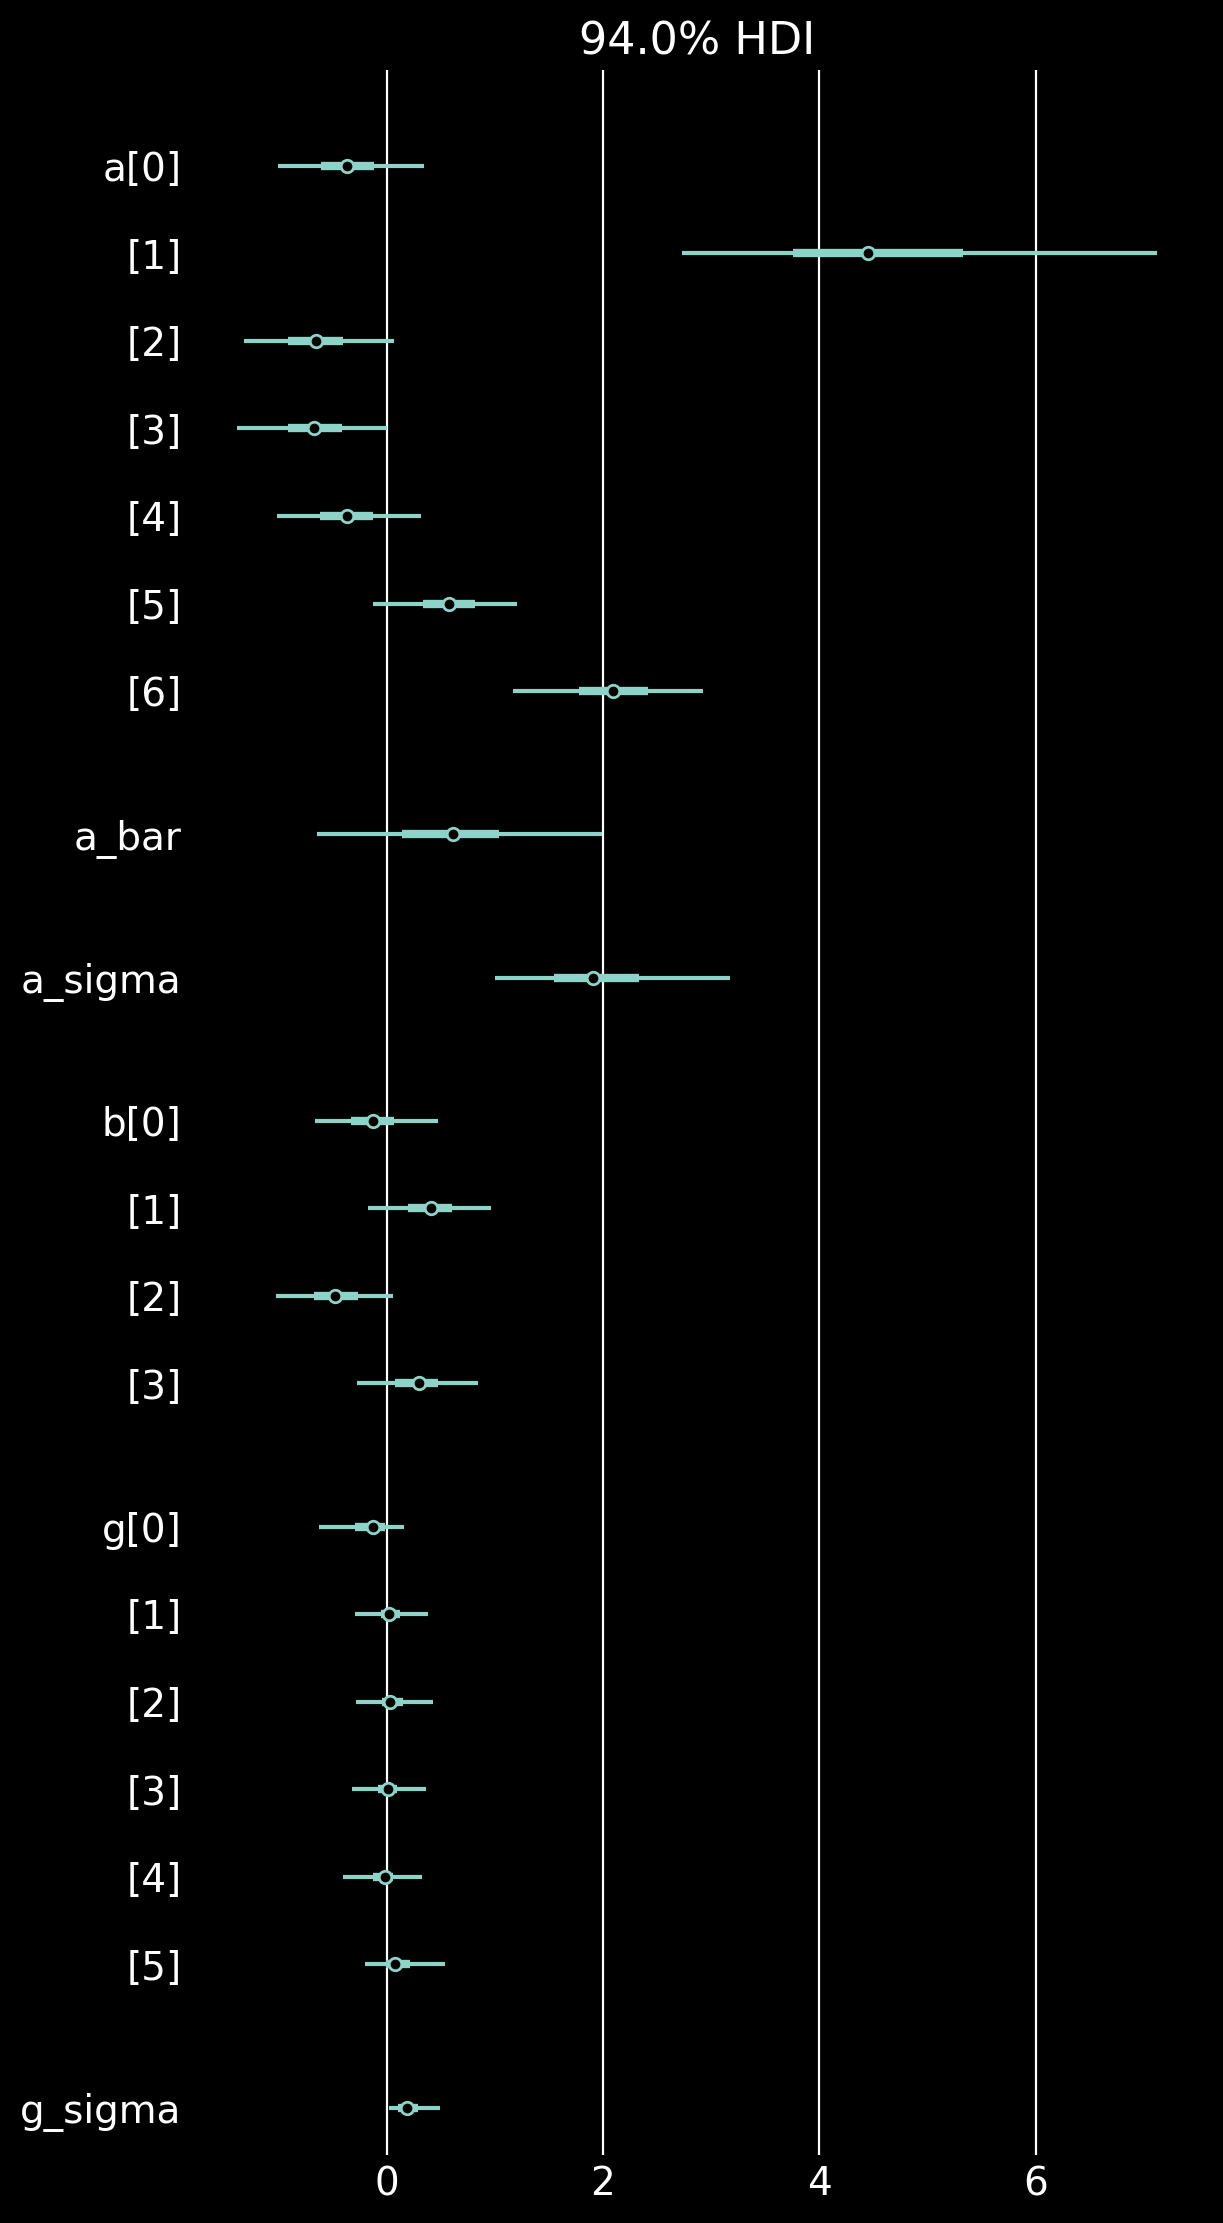

In [62]:
az.plot_forest(m4, combined=True, var_names=['~p']);

In [ ]:
## without block
def model(actor, treatment, pulled_left=None):
    a_bar = sample("a_bar", dist.Normal(0, 1.5))
    a_sig = sample("a_sigma", dist.Exponential(1))
    a = sample("a", dist.Normal(a_bar, a_sig), sample_shape=actors.shape)
    b = sample("b", dist.Normal(0, 0.5), sample_shape=treatments.shape)
    logit_p = a[actor] + b[treatment]
    deterministic("p", logistic(logit_p))
    sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m5 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m5.run(key(), dat['actor'], dat['treatment'], dat['pulled_left'])

In [64]:
m5.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.35      0.34     -0.35     -0.94      0.18    450.06      1.00
      a[1]      4.70      1.34      4.47      2.64      6.45    597.08      1.01
      a[2]     -0.65      0.34     -0.66     -1.25     -0.14    425.09      1.00
      a[3]     -0.65      0.35     -0.64     -1.21     -0.06    436.02      1.00
      a[4]     -0.35      0.34     -0.36     -0.90      0.23    454.55      1.00
      a[5]      0.58      0.34      0.58      0.02      1.14    512.71      1.00
      a[6]      2.10      0.45      2.08      1.35      2.81    679.17      1.00
     a_bar      0.61      0.73      0.61     -0.62      1.74    993.78      1.00
   a_sigma      2.02      0.67      1.91      1.07      3.02    959.35      1.01
      b[0]     -0.13      0.29     -0.13     -0.61      0.36    381.80      1.00
      b[1]      0.39      0.29      0.40     -0.04      0.92    400.22      1.00
      b[2]     -0.48      0

In [ ]:
## pooling treatments
def model(actor, block_id, treatment, pulled_left=None):
    a_bar = sample("a_bar", dist.Normal(0, 1.5))
    a_sig = sample("a_sigma", dist.Exponential(1))
    g_sig = sample("g_sigma", dist.Exponential(1))
    ## just add a common distribution for b's
    b_sig = sample("b_sigma", dist.Exponential(1))
    a = sample("a", dist.Normal(a_bar, a_sig), sample_shape=actors.shape)
    g = sample("g", dist.Normal(0, g_sig), sample_shape=blocks.shape)
    b = sample("b", dist.Normal(0, b_sig), sample_shape=treatments.shape)
    logit_p = a[actor] + g[block_id] + b[treatment]
    deterministic("p", logistic(logit_p))
    sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m6 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m6.run(key(), **dat)

In [66]:
m6.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.37      0.44     -0.37     -1.09      0.29    283.39      1.01
      a[1]      4.69      1.33      4.49      2.57      6.59    582.75      1.01
      a[2]     -0.67      0.44     -0.67     -1.40     -0.00    286.82      1.01
      a[3]     -0.67      0.45     -0.68     -1.38      0.03    298.18      1.01
      a[4]     -0.36      0.44     -0.37     -1.08      0.32    286.47      1.01
      a[5]      0.58      0.45      0.55     -0.12      1.29    265.72      1.01
      a[6]      2.10      0.53      2.08      1.26      2.97    405.17      1.00
     a_bar      0.56      0.77      0.56     -0.73      1.82    755.01      1.00
   a_sigma      2.05      0.67      1.94      1.07      2.97    648.39      1.01
      b[0]     -0.11      0.39     -0.10     -0.74      0.48    252.03      1.01
      b[1]      0.38      0.40      0.35     -0.21      0.98    239.77      1.01
      b[2]     -0.45      0

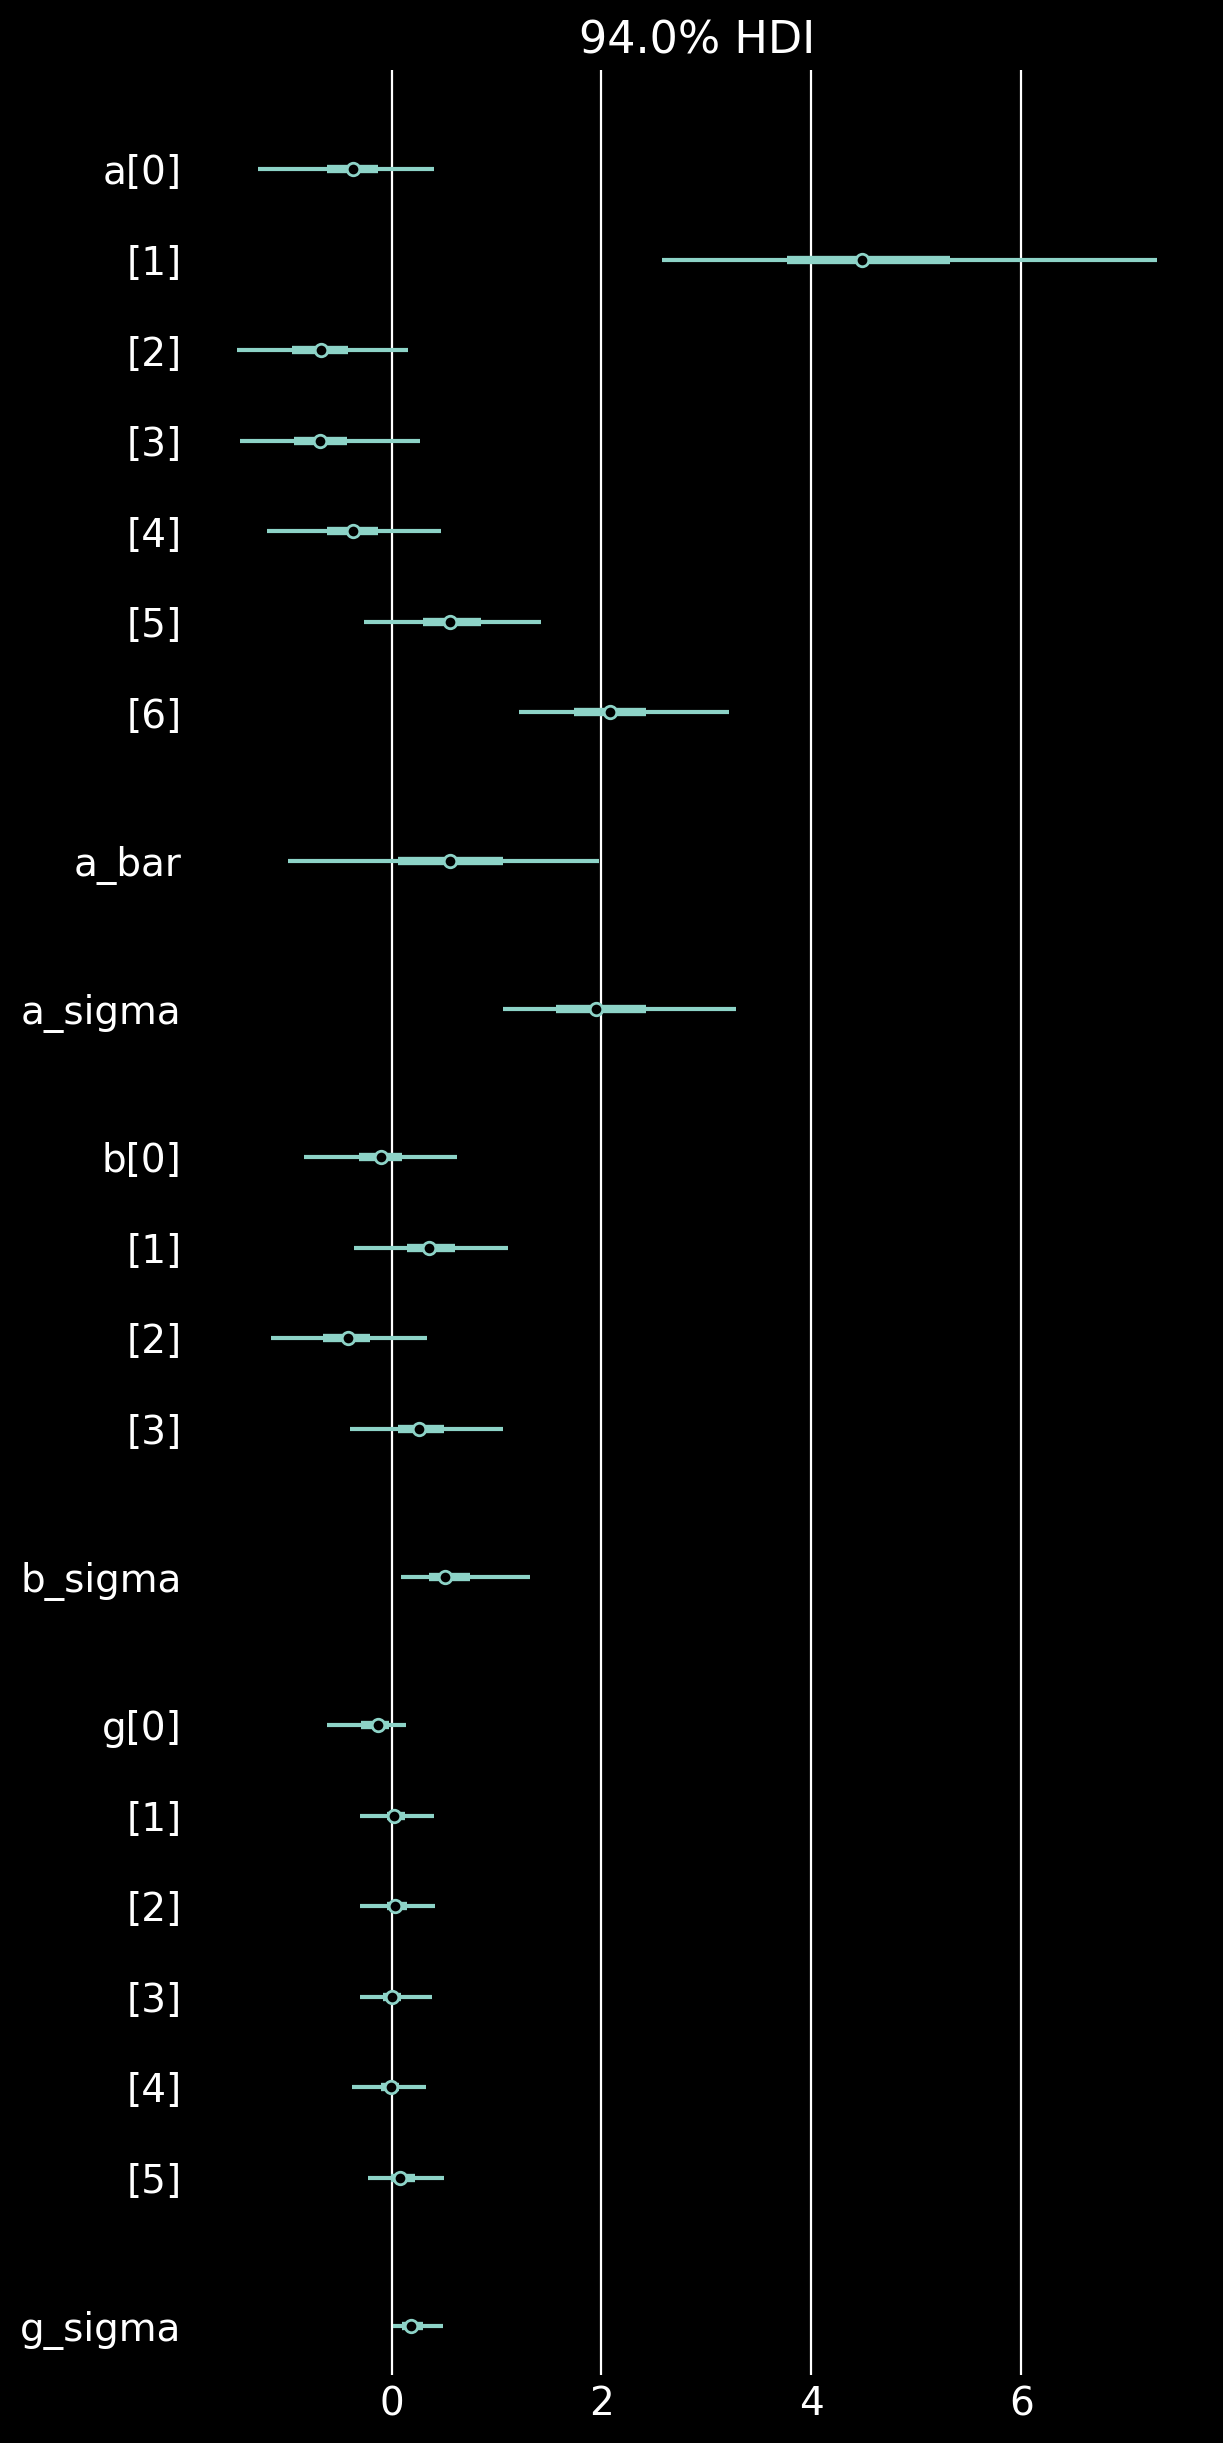

In [67]:
az.plot_forest(m6,var_names=['~p'], combined=True);

In [68]:
## note p_waic, number of effective parameters
az.compare({"m4": m4, "m5": m5, "m6": m6},
    ic="waic", scale="deviance", method="BB-pseudo-BMA")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5,0,531.172773,8.567398,0.000000,0.498118,19.523693,0.000000,False,deviance
m4,1,532.245808,10.721368,1.073035,0.291591,19.221020,1.765744,False,deviance
m6,2,532.895208,10.890358,1.722435,0.210291,19.432449,1.763203,False,deviance


In [ ]:
## using non-centered params
def model4b(actor, block_id, treatment, pulled_left=None):
    a_bar = sample("a_bar", dist.Normal(0, 1.5))
    a_sig = sample("a_sigma", dist.Exponential(1))
    g_sig = sample("g_sigma", dist.Exponential(1))
    Z_a = sample("Z_a", dist.Normal(), sample_shape=actors.shape)
    Z_g = sample("Z_g", dist.Normal(), sample_shape=blocks.shape)
    a = deterministic("a", a_bar + Z_a * a_sig)
    g = deterministic("g", Z_g * g_sig)
    b = sample("b", dist.Normal(0, 0.5), sample_shape=treatments.shape)
    logit_p = a[actor] + g[block_id] + b[treatment]
    deterministic("p", logistic(logit_p))
    sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m4b = MCMC(NUTS(model4b), num_warmup=500, num_samples=500, num_chains=4)
m4b.run(key(), **dat)

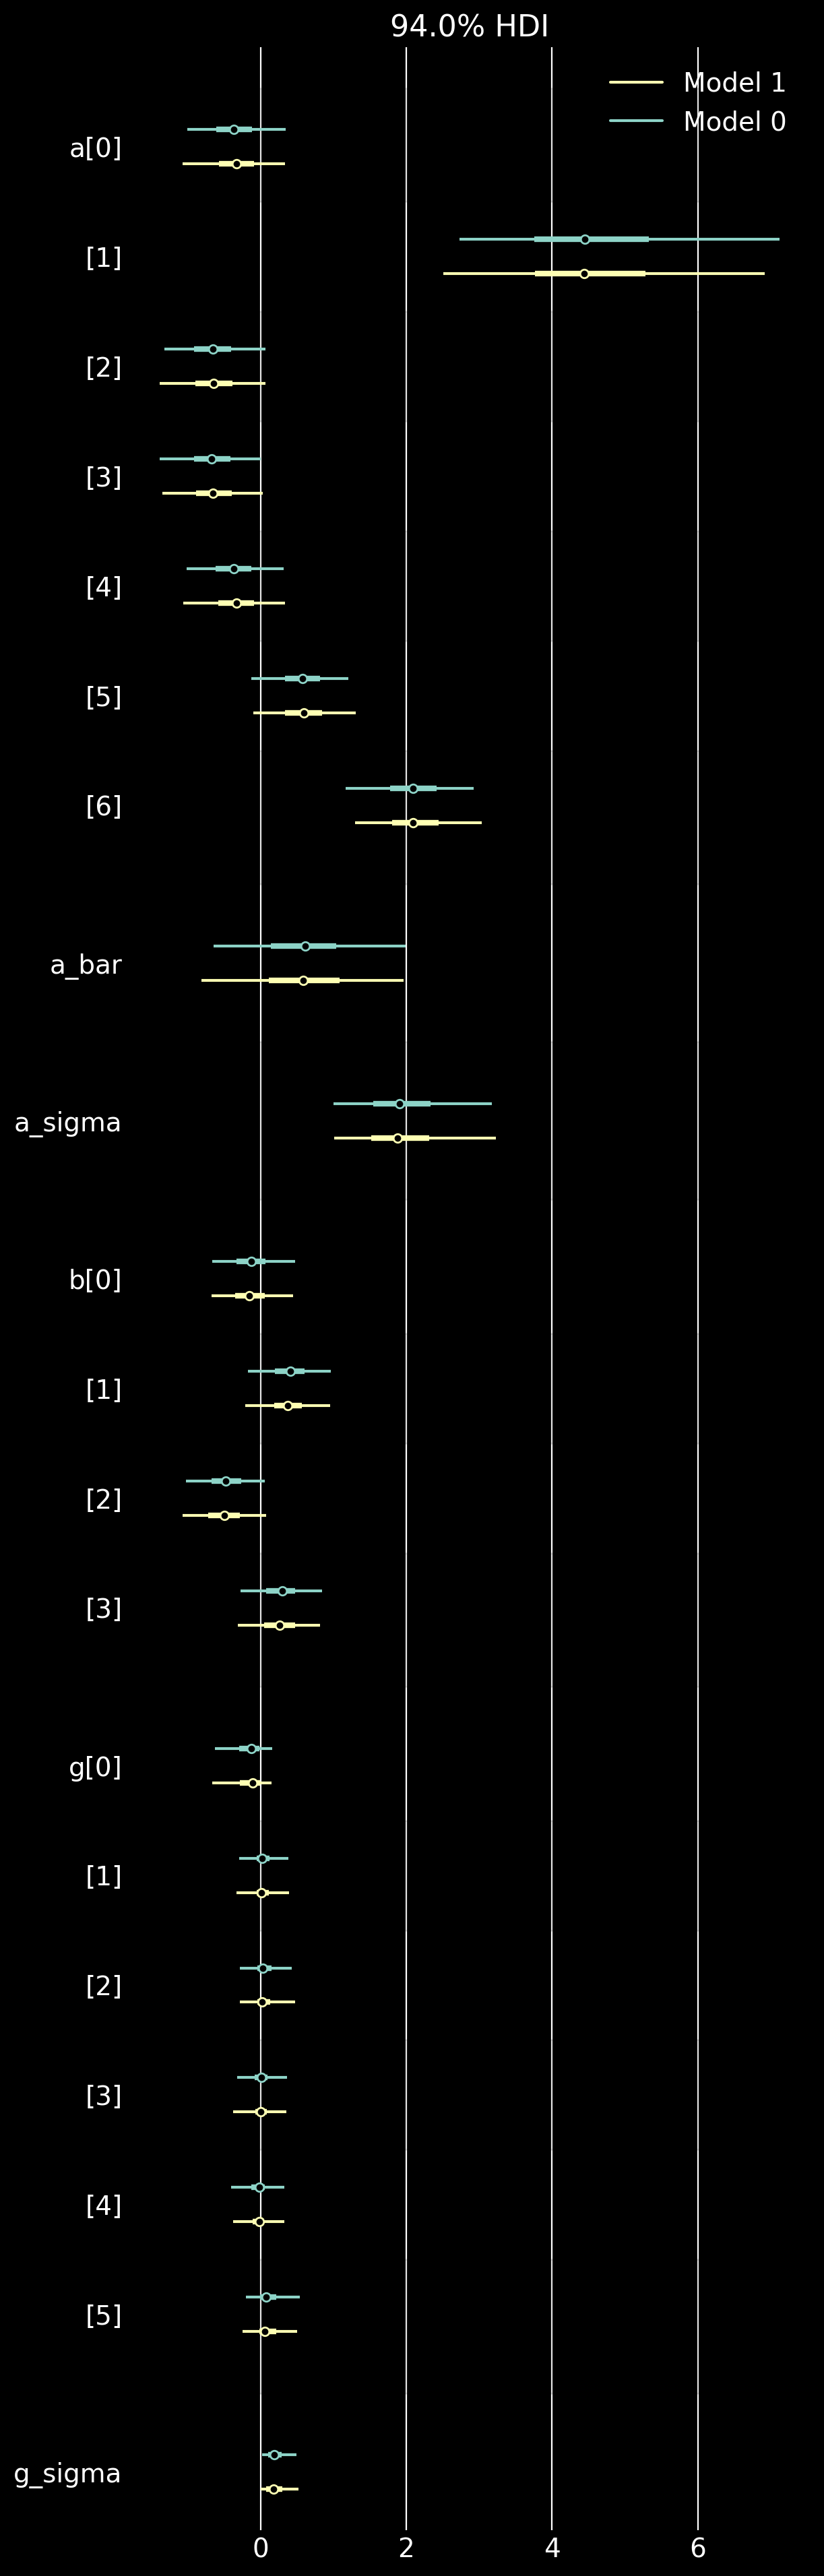

In [216]:
## same
az.plot_forest([m4, m4b], var_names=["~p","~Z_a", "~Z_g"], combined=True);

In [90]:
## posterior predictions
## model data is already mutable

## actor index 1, with block idx fixed at 0, across all treatments
d_pred = {'actor': np.repeat(1,4), 'block_id': np.repeat(0,4), 'treatment': np.arange(4)}

post4b = m4b.get_samples()
post_pred = Predictive(model4b, post4b)(key(), **d_pred)


In [115]:
post_pred['p'].mean(0)

DeviceArray([0.9779533 , 0.9868972 , 0.9691402 , 0.98501515], dtype=float32)

In [123]:
np.percentile(post_pred['p'], q=np.array([5.5,94.5]), axis=0)

DeviceArray([[0.9389133 , 0.9634087 , 0.9157581 , 0.9564718 ],
             [0.99860597, 0.99919146, 0.9980137 , 0.9991443 ]],            dtype=float32)

In [110]:
az.from_numpyro(m4b)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

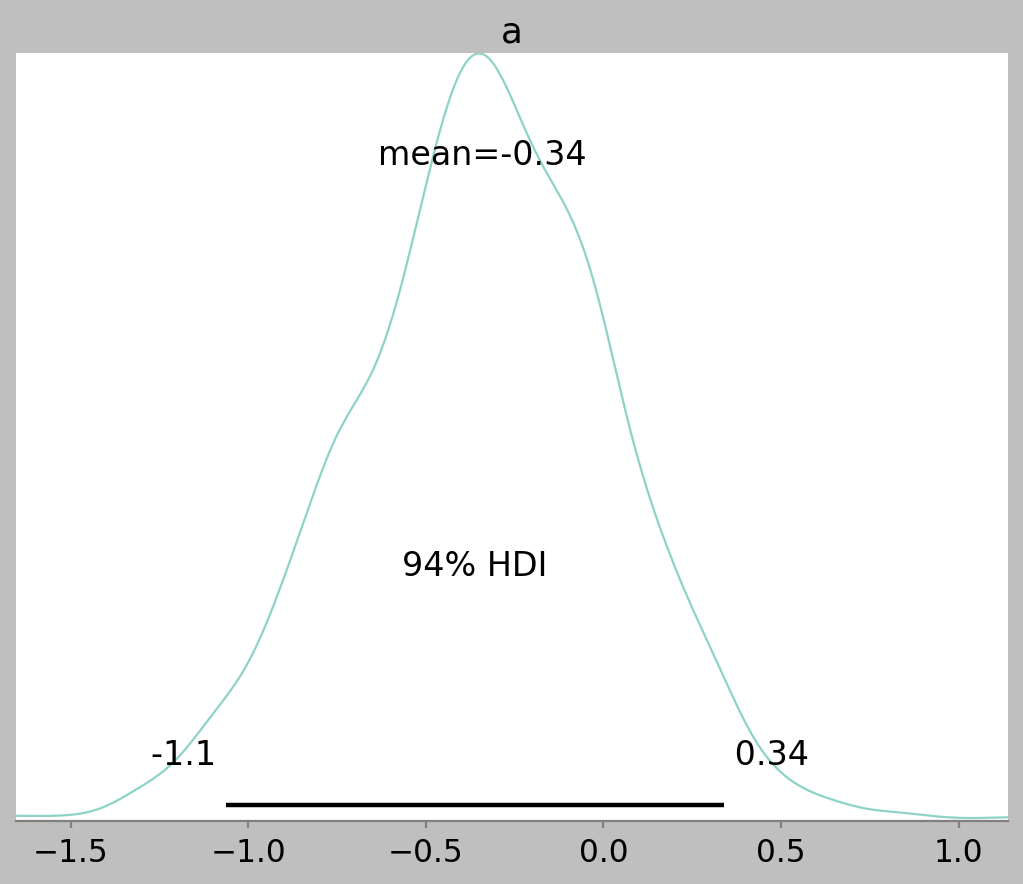

In [108]:
## arviz plot_posterior()
with plt.style.context(style="classic", after_reset=True):
    az.plot_posterior(m4b, var_names=['a'], coords={'a_dim_0': 4});

In [189]:
post4b['a_bar'][:,None] + post4b['b']

DeviceArray([[ 0.97309685,  1.2244484 ,  0.5228112 ,  1.3160349 ],
             [ 1.3207369 ,  2.1971416 ,  0.73759997,  2.2610285 ],
             [ 0.70570153,  1.6686025 ,  0.26916373,  1.5756668 ],
             ...,
             [ 0.78656393,  1.042052  ,  0.4208598 ,  1.3085    ],
             [ 0.7333342 ,  1.0689566 , -0.01610184,  1.2268398 ],
             [ 1.4254813 ,  2.1087708 ,  1.3600023 ,  1.758108  ]],            dtype=float32)

In [210]:
pred_average_actor = logistic(post4b['a_bar'][:,None] + post4b['b'])
pred_ci = np.percentile(pred_average_actor, q=np.array([5.5,94.5]), axis=0)

In [211]:
simulated_actors = dist.Normal(post4b['a_bar'], post4b['a_sigma']).sample(key())
pred_p_actors = logistic(simulated_actors[:,None] + post4b['b'])
pred_p_ci = np.percentile(pred_p_actors, q=np.array([5.5,94.5]), axis=0)

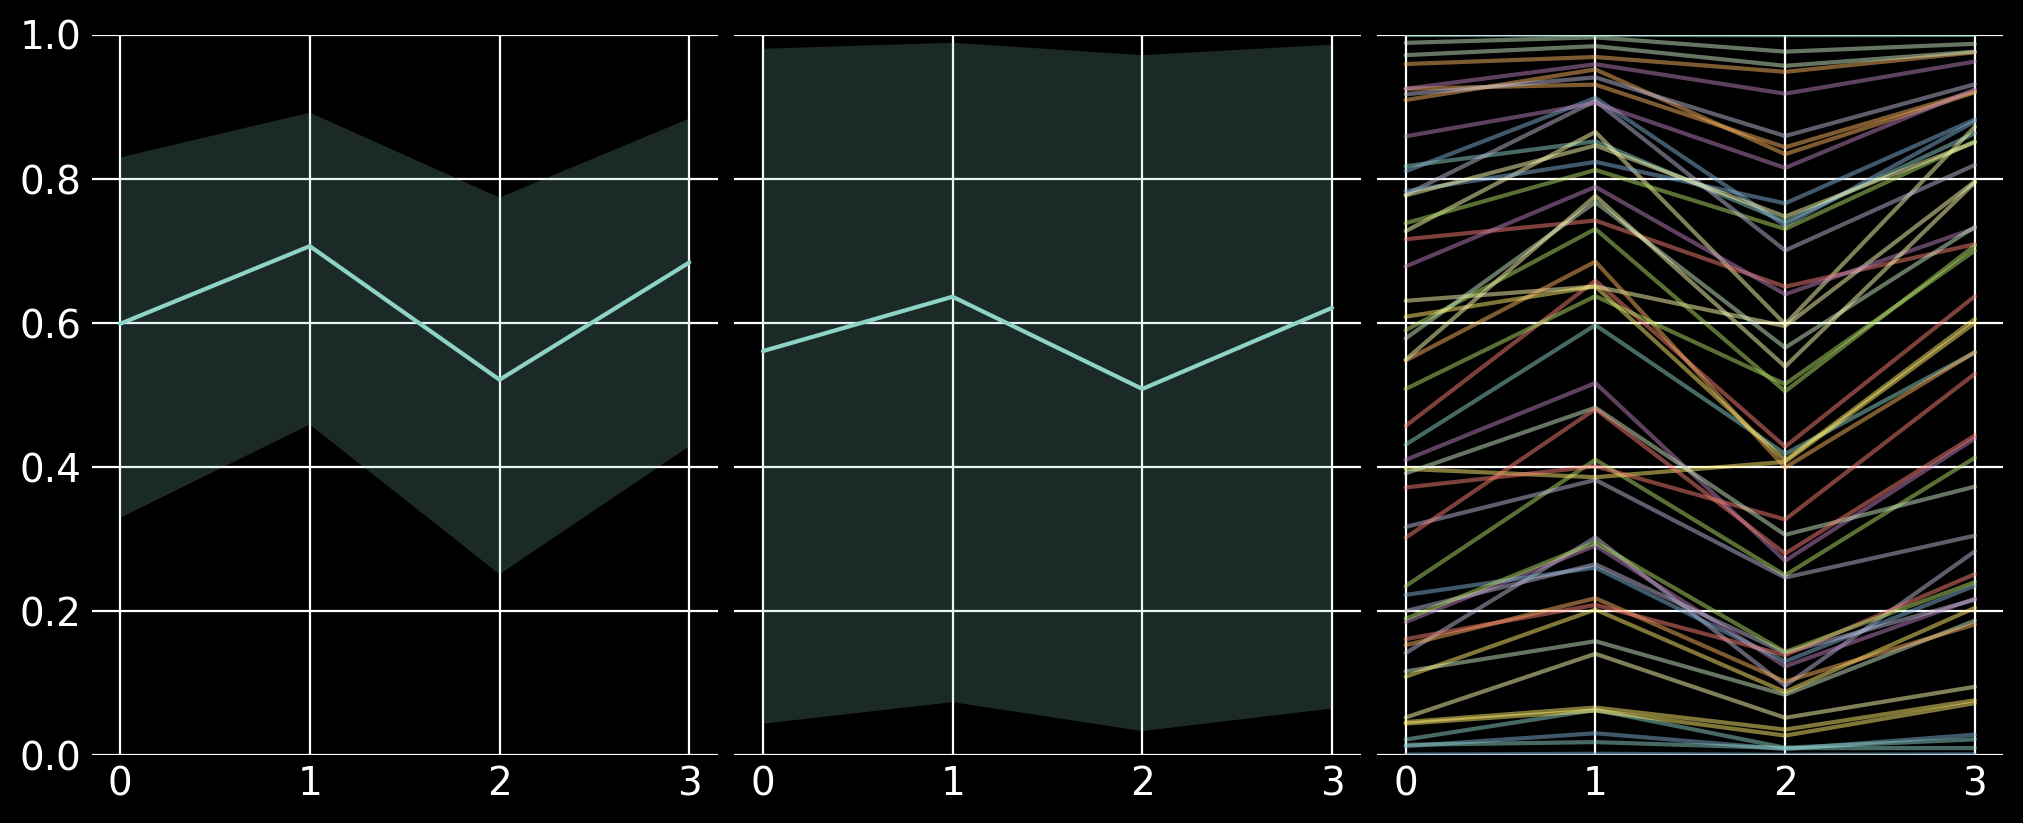

In [213]:
_, ax = plt.subplots(1,3,sharey=True, figsize=(10,4))
ax[0].set_ylim(0,1)
x = np.arange(4)
ax[0].plot(x, pred_average_actor.mean(0))
#az.plot_hdi(x, pred_average_actor, ax=ax[0])
ax[0].fill_between(np.arange(4), pred_ci[0], pred_ci[1], alpha=0.2)
## mean of variation among actors = marginal of actor
ax[1].plot(x, pred_p_actors.mean(0))
ax[1].fill_between(np.arange(4), pred_p_ci[0], pred_p_ci[1], alpha=0.2)
## simulated actors
for i in range(50):
    ax[2].plot(x, pred_p_actors[i,:], alpha=0.5);